In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# dir = "/content/drive/MyDrive/Colab Notebooks/EECS4422/A3/"

In [ ]:
pip install kornia

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
from scipy.spatial import distance
import random
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
from kornia.feature import *
from kornia.geometry import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

In [ ]:
# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [ ]:
# img1 = cv2.imread(dir + 'parliament-left.jpg')
# h,w,_ = img1.shape
# img3 = np.zeros((h,w*2,3),dtype = np.uint8)
# img3[:img1.shape[0],:img1.shape[1],:] = img1
# img1 = img3

# img2 = cv2.imread(dir + 'parliament-right.jpg')
# img3 = np.zeros((h,w*2,3),dtype = np.uint8)
# img3[:img2.shape[0],:img2.shape[1],:] = img2
# img2 = img3

# timg1 = kornia.utils.image_to_tensor(np.array(img1), False).float() / 255.
# timg2 = kornia.utils.image_to_tensor(np.array(img2), False).float() / 255.

# timg = torch.cat([timg1,timg2], dim=0)

# timg_gray = kornia.color.rgb_to_grayscale(timg)

# plt.imshow(kornia.utils.tensor_to_image(timg[0]))
# plt.figure()
# plt.imshow(kornia.utils.tensor_to_image(timg[1]))

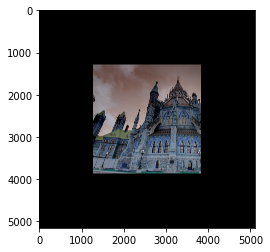

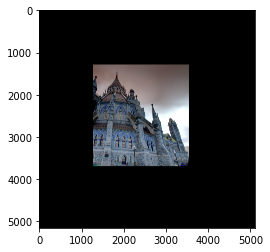

In [ ]:
img1 = cv2.imread('parliament-left.jpg')
img2 = cv2.imread('parliament-right.jpg')
h,w,_ = img1.shape
multiplier = 2
hoff = int(h*multiplier)
woff = int(w*multiplier)
hpad = int((h*multiplier - h)/2)
wpad = int((w*multiplier - w)/2)

temp = np.zeros((hoff,woff,3),dtype = np.uint8)
temp[hpad:img2.shape[0]+hpad,wpad:img2.shape[1]+wpad,:] = img2
img2 = temp
temp = np.zeros((hoff,woff,3),dtype = np.uint8)
temp[hpad:img1.shape[0]+hpad,wpad:img1.shape[1]+wpad,:] = img1
img1 = temp

timg1 = kornia.utils.image_to_tensor(np.array(img1), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img2), False).float() / 255.

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = kornia.color.rgb_to_grayscale(timg)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

In [ ]:
def findFeatures(img):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(img, None)

    out1  = cv2.drawKeypoints(gray,keypoints,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(dpi=200)
    plt.imshow(out1)

    return keypoints, descriptors

In [ ]:
#def matchFeatures(des1,des2):
  

In [ ]:
#def main():



In [ ]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [ ]:
def geometricDistance(pair, h):

    p1 = np.transpose(np.matrix([pair[0], pair[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([pair[2], pair[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [ ]:
def ransac(pair, thresh):
    maxInliers = []
    finalH = None
    for i in range(2000):
        #find 4 random points to calculate a homography
        p1 = pair[random.randint(0,len(pair)-1)]
        p2 = pair[random.randint(0,len(pair)-1)]
        p3 = pair[random.randint(0,len(pair)-1)]
        p4 = pair[random.randint(0,len(pair)-1)]
        fourStack = np.vstack((p1, p2))
        fourStack = np.vstack((fourStack, p3))
        fourStack = np.vstack((fourStack, p4))
        #call the homography function on those points
        h = calculateHomography(fourStack)
        inliers = []

        for i in range(len(pair)):
            d = geometricDistance(pair[i], h)
            if d < 5:
                inliers.append(pair[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h

        if len(maxInliers) > (len(pair)*thresh):
            break
    return finalH, maxInliers

In [ ]:
def Assignment3(leftimg, rightimg, thresh = 50):
    kp1, des1 = findFeatures(leftimg)
    kp2, des2 = findFeatures(rightimg)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m,n in matches:
        if( (m.distance / n.distance) < .8 ): #ratio test https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
            good_matches.append(m)

    print(len(good_matches))

    pruned_matches = []
    for i in good_matches:
      if i.distance < thresh:
        pruned_matches.append(i)
    print(len(pruned_matches))

    pair = []
    for i in pruned_matches:

        # Get the matching keypoints for each of the images
        img1_idx = i.queryIdx
        img2_idx = i.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt
        pair.append([x1,y1,x2,y2])

    pair = np.asarray(pair)

    fig, ax = plt.subplots(figsize=(20,10))
    plot_inlier_matches(ax, leftimg, rightimg, pair)

    h,inliers = ransac(pair,.05)

    # 1) perform warping on image and visualize overlapping pair
    t = torch.tensor(h, dtype = torch.float)
    t = t.unsqueeze(0)
    _,_,height,width = timg1.shape
    out = kornia.geometry.warp_perspective(timg1,t,(height,width))
    maximum = torch.max(out,timg2)
    maximum = kornia.color.bgr_to_rgb(maximum) 
    plt.figure(figsize=(20,10))
    plt.imshow(kornia.utils.tensor_to_image(maximum))
    return maximum

8247
3959


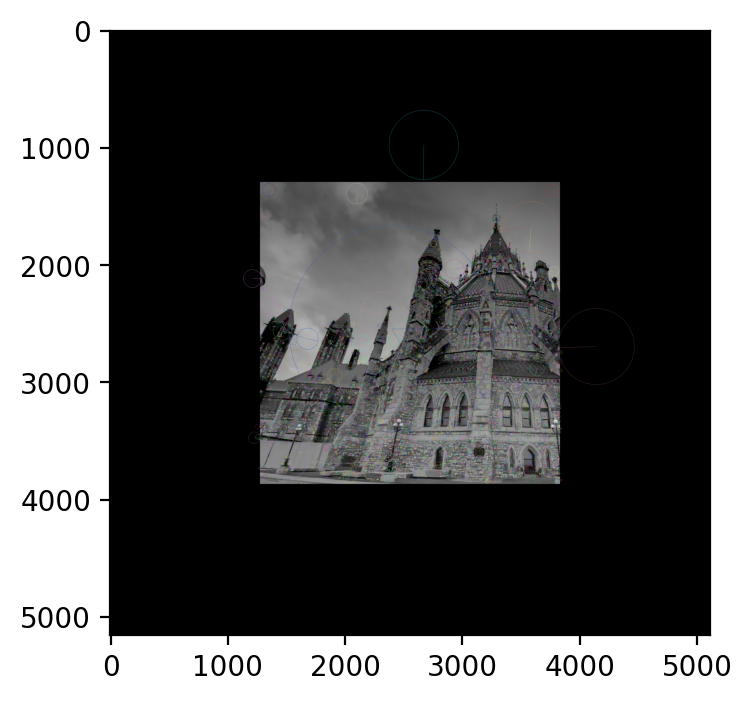

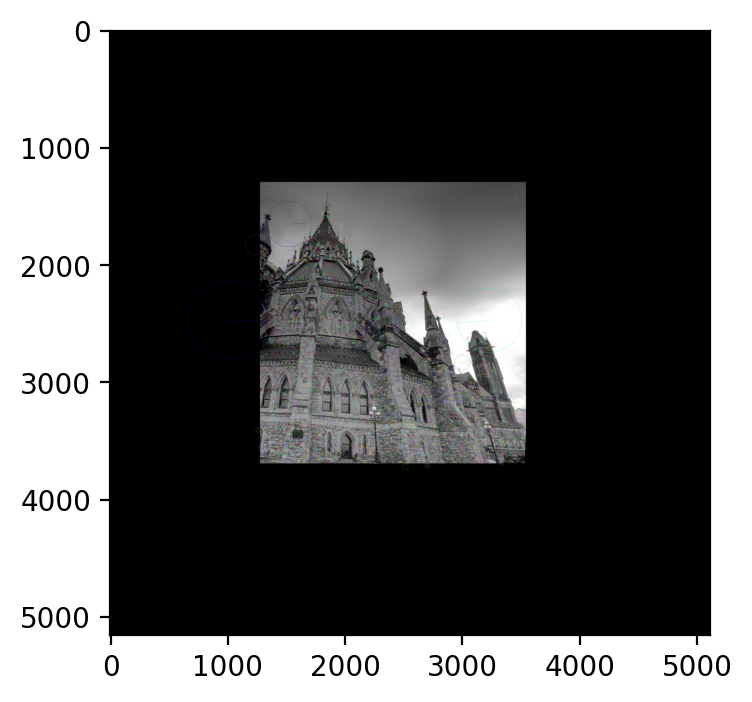

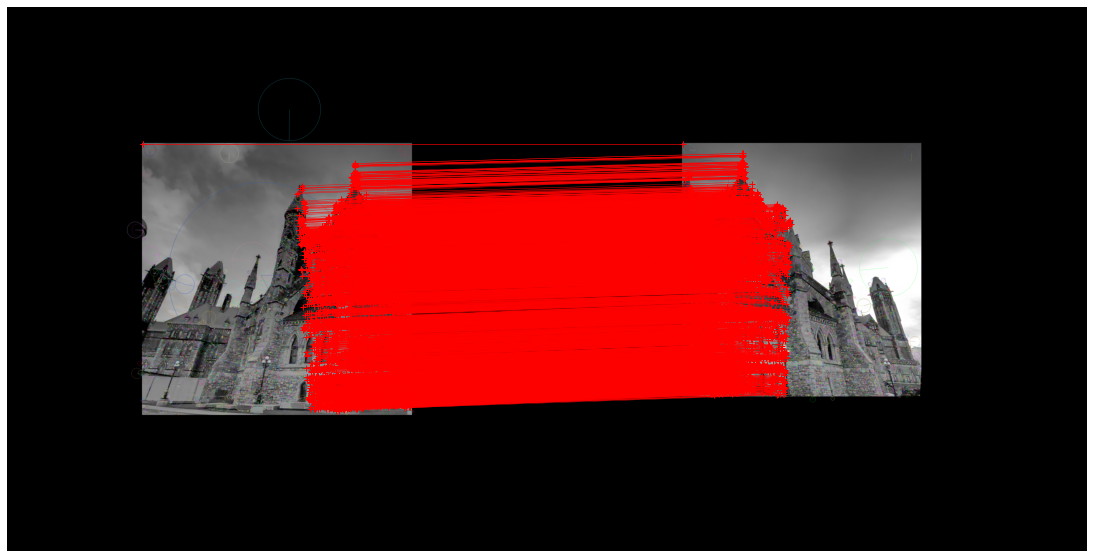

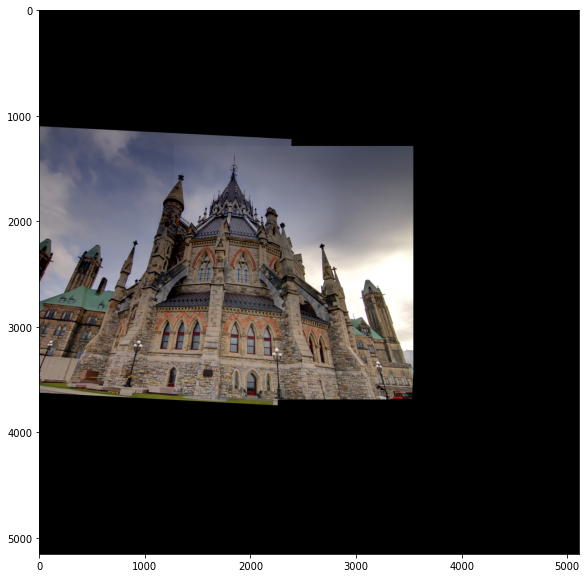

In [ ]:
newImg = Assignment3(img1,img2)

In [ ]:
# kp1, des1 = findFeatures(img1)
# kp2, des2 = findFeatures(img2)

# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des1, des2, k=2)

# good_matches = []
# for m,n in matches:
#     if( (m.distance / n.distance) < .8 ): #ratio test https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
#         good_matches.append(m)

# print(len(good_matches))

# pruned_matches = []
# for i in good_matches:
#   if i.distance < 50:
#     pruned_matches.append(i)
# print(len(pruned_matches))

# pair = []
# for i in pruned_matches:

#     # Get the matching keypoints for each of the images
#     img1_idx = i.queryIdx
#     img2_idx = i.trainIdx

#     # x - columns, y - rows
#     (x1,y1) = kp1[img1_idx].pt
#     (x2,y2) = kp2[img2_idx].pt
#     pair.append([x1,y1,x2,y2])

# pair = np.asarray(pair)

# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, pair)

# h,inliers = ransac(pair,.05)

In [ ]:
# # 1) perform warping on image and visualize overlapping pair
# t = torch.tensor(h, dtype = torch.float)
# t = t.unsqueeze(0)
# _,_,height,width = timg1.shape
# out = kornia.geometry.warp_perspective(timg1,t,(height,width))
# max = torch.max(out,timg2)
# outNP = kornia.utils.tensor_to_image(out)
# outNP *= 255 
# newImg = np.zeros((height,width*2,3), dtype = np.uint8)
# newImg[:img1.shape[0],:img1.shape[1],:] = img1
# newImg[:,img1.shape[1]:,:] = outNP
# max = kornia.color.bgr_to_rgb(max) 
# plt.figure(figsize=(20,10))
# plt.imshow(kornia.utils.tensor_to_image(max))

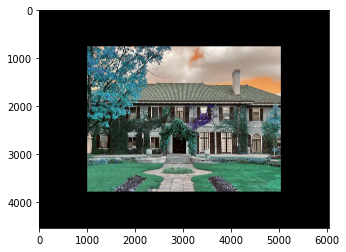

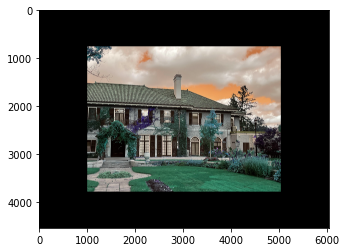

In [ ]:

img4 = cv2.imread('Glendon-Hall-middle.jpg')
img5 = cv2.imread('Glendon-Hall-right.jpg')
h,w,_ = img4.shape
multiplier = 1.5
hoff = int(h*multiplier)
woff = int(w*multiplier)
hpad = int((h*multiplier - h)/2)
wpad = int((w*multiplier - w)/2)

temp = np.zeros((hoff,woff,3),dtype = np.uint8)
temp[hpad:img5.shape[0]+hpad,wpad:img5.shape[1]+wpad,:] = img5
img5 = temp
temp = np.zeros((hoff,woff,3),dtype = np.uint8)
temp[hpad:img4.shape[0]+hpad,wpad:img4.shape[1]+wpad,:] = img4
img4 = temp

timg1 = kornia.utils.image_to_tensor(np.array(img4), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img5), False).float() / 255.

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = kornia.color.rgb_to_grayscale(timg)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

18859
2487


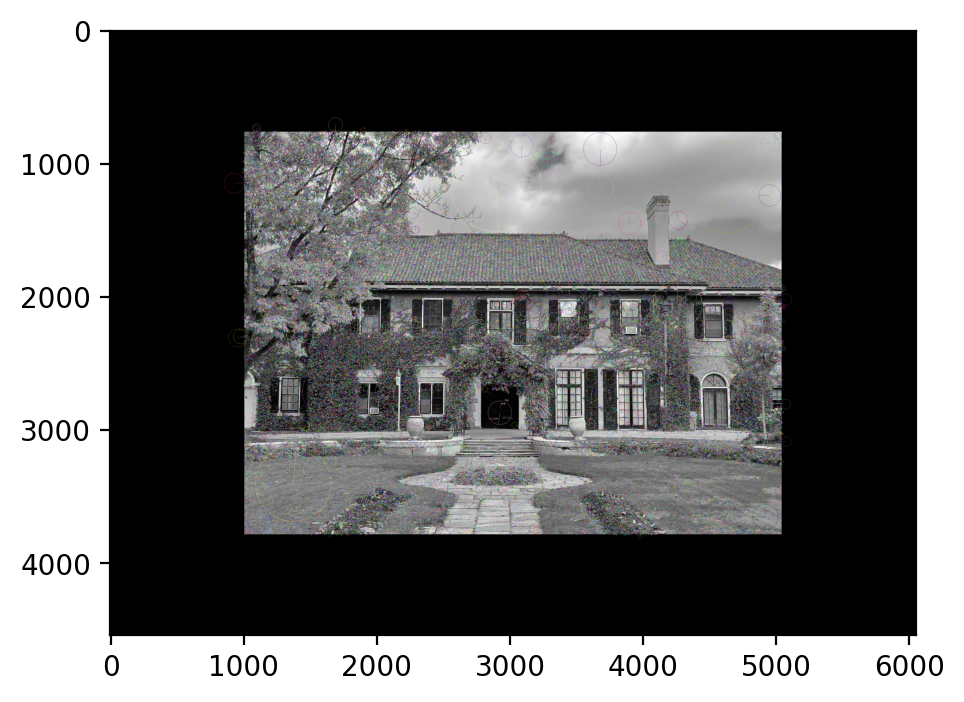

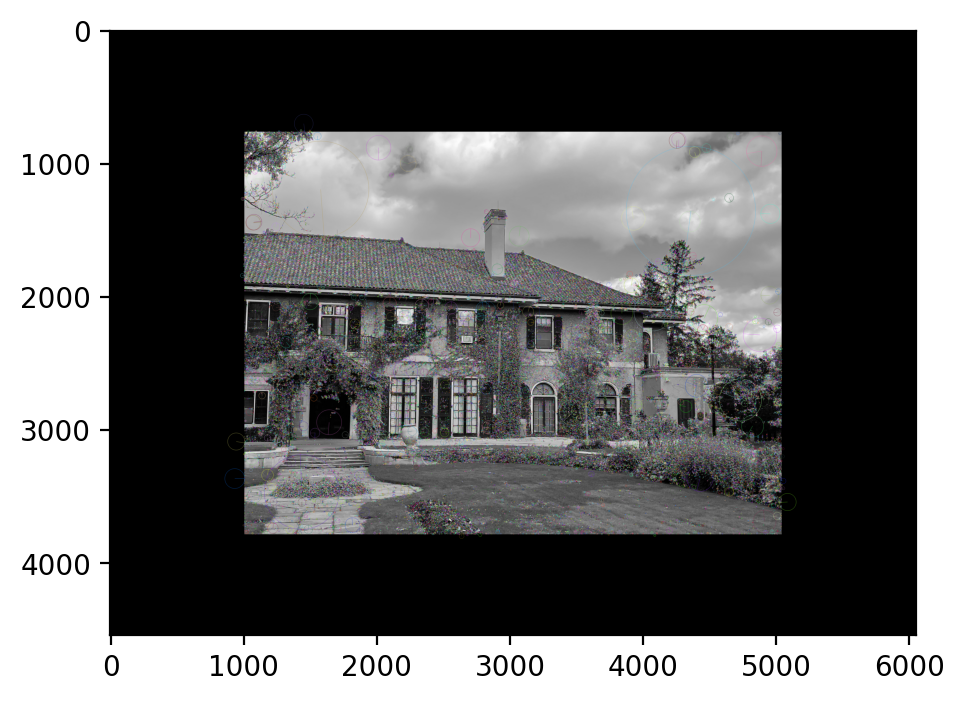

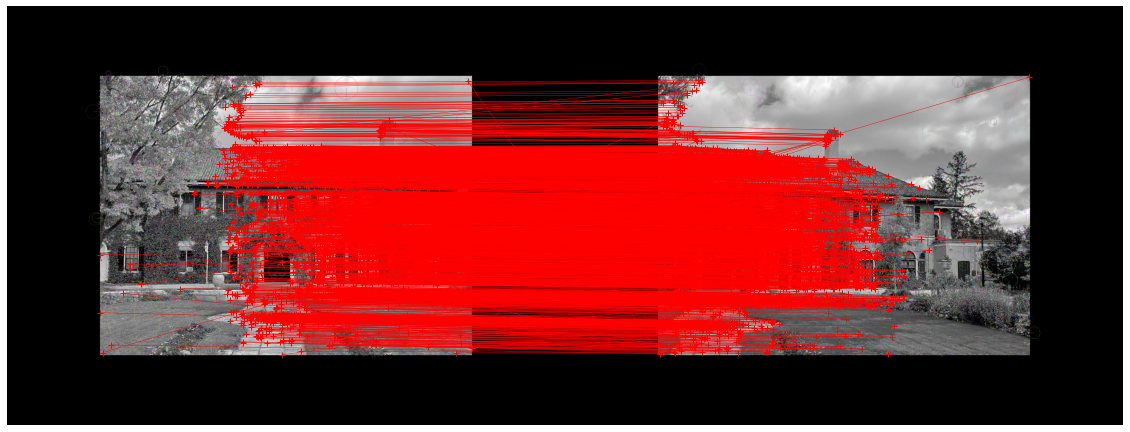

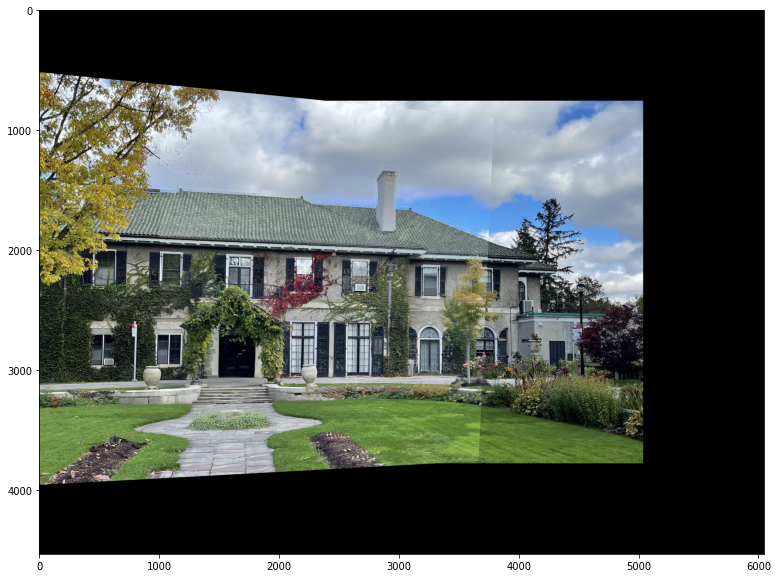

In [ ]:
newImg = Assignment3(img4,img5, 100) #I'm sorry Matt, I hope you have a beastly PC

In [ ]:
copy = newImg

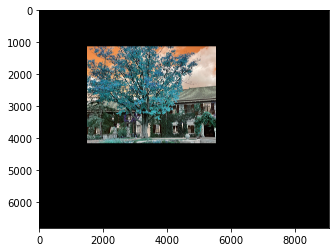

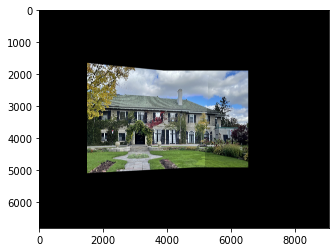

In [ ]:
img3 = cv2.imread('Glendon-Hall-left.jpg')
newImg = kornia.utils.tensor_to_image(newImg)
newImg *= 255
h,w,_ = newImg.shape
multiplier = 1.5
hoff = int(h*multiplier)
woff = int(w*multiplier)
hpad = int((h*multiplier - h)/2)
wpad = int((w*multiplier - w)/2)

temp = np.zeros((hoff,woff,3),dtype = np.uint8)
temp[hpad:newImg.shape[0]+hpad,wpad:newImg.shape[1]+wpad,:] = newImg
newImg = temp
temp = np.zeros((hoff,woff,3),dtype = np.uint8)
temp[hpad:img3.shape[0]+hpad,wpad:img3.shape[1]+wpad,:] = img3
img3 = temp

timg1 = kornia.utils.image_to_tensor(np.array(img3), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(newImg), False).float() / 255.

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = kornia.color.rgb_to_grayscale(timg)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))


10210
533


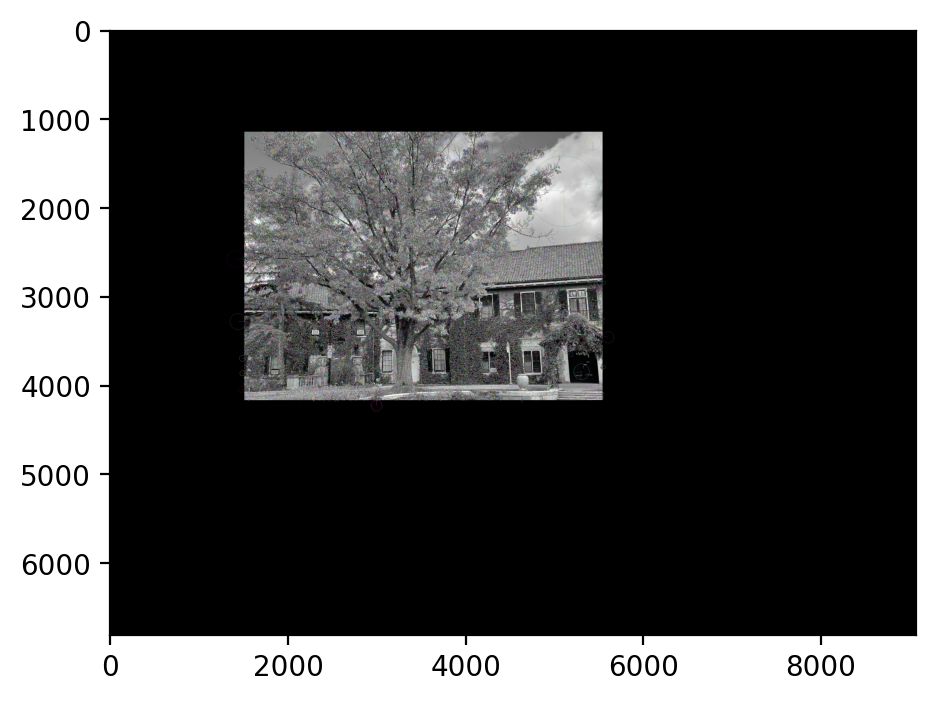

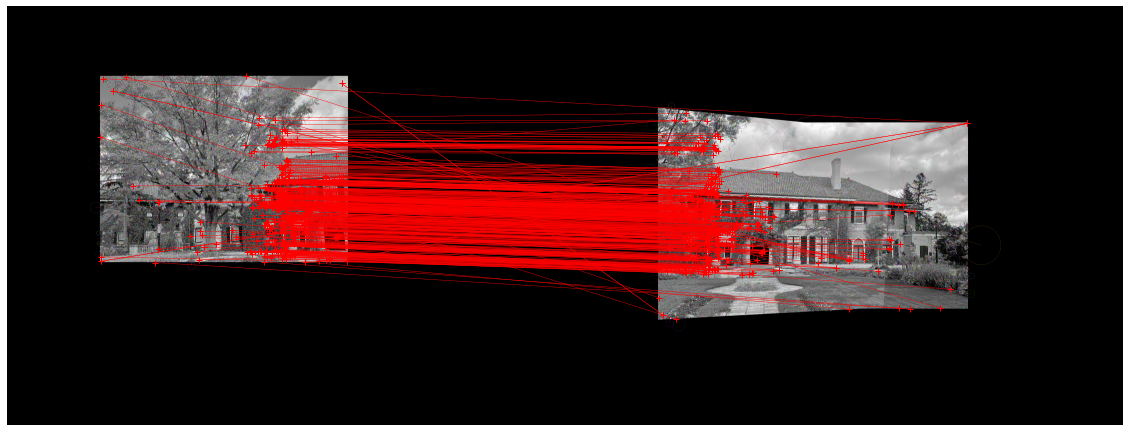

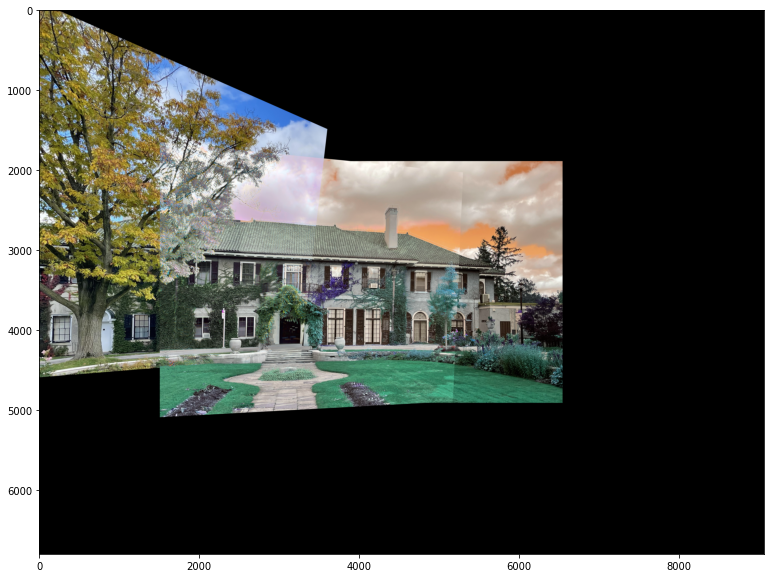

In [ ]:
panorama = Assignment3(img3,newImg, 100) #haha....